In [1]:
import emcee
import numpy as np
from scipy import stats
import chainconsumer 
from cobaya.run import run
import matplotlib.pyplot as plt
from scipy.integrate import quad

%config InlineBackend.figure_format = 'svg'

In [2]:
# Load table
csv_table = np.loadtxt('data.csv', skiprows=1, delimiter=',', dtype='S', usecols=(1, 2, 3))


redshifts = csv_table[:, 0].astype(np.float) # redshifts

f_gas_colSCDM = np.array([np.array(i.split()).astype(np.float) for i in csv_table[:, 1]]) # SCDM column
f_gas_SCDM, sigma_SCDM = f_gas_colSCDM[:, 0], f_gas_colSCDM[:, 1]

f_gas_colLambdaCDM = np.array([np.array(i.split()).astype(np.float) for i in csv_table[:, 2]]) # LambdaCDM column
f_gas_LambdaCDM, sigma_LambdaCDM = f_gas_colLambdaCDM[:, 0], f_gas_colLambdaCDM[:, 1]

# Create dictionary from table data
data = {}
data['z'] = redshifts
data['f_gas_SCDM'] = f_gas_SCDM
data['sigma_SCDM'] = sigma_SCDM

data['f_gas_LambdaCDM'] = f_gas_LambdaCDM
data['sigma_LambdaCDM'] = sigma_LambdaCDM

In [3]:
# Print data as a table
print('z          f_gas_SCDM     f_gas_LambdaCDM')

for i in range(len(data['z'])):
    print('{}     {}+/-{}     {}+/-{}'.format(data['z'][i], data['f_gas_SCDM'][i], data['sigma_SCDM'][i], 
                                          data['f_gas_LambdaCDM'][i], data['sigma_LambdaCDM'][i]))

z          f_gas_SCDM     f_gas_LambdaCDM
0.078     0.189+/-0.011     0.121+/-0.008
0.088     0.184+/-0.011     0.12+/-0.008
0.143     0.167+/-0.019     0.114+/-0.013
0.188     0.169+/-0.011     0.122+/-0.009
0.206     0.18+/-0.015     0.128+/-0.012
0.208     0.137+/-0.018     0.098+/-0.013
0.24     0.163+/-0.009     0.115+/-0.005
0.252     0.164+/-0.012     0.112+/-0.012
0.288     0.149+/-0.017     0.111+/-0.016
0.313     0.169+/-0.01     0.124+/-0.009
0.314     0.175+/-0.023     0.13+/-0.018
0.324     0.177+/-0.018     0.139+/-0.017
0.345     0.173+/-0.019     0.13+/-0.016
0.352     0.189+/-0.025     0.145+/-0.022
0.363     0.159+/-0.017     0.114+/-0.017
0.391     0.159+/-0.024     0.123+/-0.02
0.399     0.177+/-0.017     0.141+/-0.015
0.45     0.155+/-0.019     0.119+/-0.018
0.451     0.137+/-0.009     0.108+/-0.009
0.461     0.129+/-0.019     0.106+/-0.018
0.461     0.156+/-0.034     0.131+/-0.029
0.494     0.094+/-0.025     0.072+/-0.022
0.539     0.135+/-0.011     0.113+/-0.008


In [70]:
def E_z(z, omega_m, omega_X, omega_K, w_X):
    f_z = (1+z)**(3*(1+w_X))
    return np.sqrt(omega_m*(1+z)**3 + omega_X*f_z + omega_K*(1+z)**2)

def one_over_E_z(z, omega_m, omega_X, omega_K, w_X):
    return 1/E_z(z, omega_m, omega_X, omega_K, w_X)

def d_A(z, omega_m, omega_X, omega_K, h, w_X):
    H0 = h*100
    
    c = 299792.458 # c in km/s
    
    integral = quad(one_over_E_z, 0, z, args=(omega_m, omega_X, omega_K, w_X))[0]
    if omega_K==0.:
        pre_factor = c/(H0*(1+z))
        return pre_factor*integral
    else:
        pre_factor = c/(H0*(1+z)*omega_K**0.5)
        return pre_factor*np.sinh(omega_K**0.5*integral)

def f_model(z, omega_m, omega_X, omega_K, omega_b, h, w_X, b):
    '''
    SCDM cosmology: omega_m = 1., h=0.5, omega_K=omega_X=0
    '''
    d_SCDM = d_A(z, omega_m=1., omega_X=0., omega_K=0., h=0.5, w_X=0.) #reference cosmology 1
#     d_lambdaCDM = d_A(z, omega_m=.3, omega_X=0.7, omega_K=0., h=0.7, w_X=0.) #reference cosmology 2
    
    d_model = d_A(z, omega_m, omega_X, omega_K, h, w_X)
    
    return b*omega_b/((1 + 0.19*h**0.5)*omega_m) * (d_SCDM/d_model)**1.5
    
    
    
def log_likelihood(omega_m, omega_X, omega_K, omega_b, h, w_X, b):
    z, f_gas, f_gas_sigma = data['z'], data['f_gas_SCDM'], data['sigma_SCDM']
    
    log_likelihood = 0.
    
    for  z_i, f_gas_i, f_gas_sigma_i in zip(z, f_gas, f_gas_sigma):        
        f_gas_model = f_model(z_i, omega_m, omega_X, omega_K, omega_b, h, w_X, b)
        log_likelihood += (f_gas_i - f_gas_model)**2/f_gas_sigma_i**2
    return log_likelihood
    

In [71]:
'''
ref: initial reference value for sampling
proposal: standard deviation
'''
info = {'likelihood': {'log_like': log_likelihood}}

info['params'] = {
    'omega_m': 0.3,#{'prior': {'min': 0., 'max': 1.}, 'ref': {'dist': 'norm', 'loc': 0.3, 'scale': 0.01}, 'latex':r'\Omega_m'},
    'omega_X': 0.7,#{'prior': {'min': 0., 'max': 1.}, 'ref': {'dist': 'norm', 'loc': 0.7, 'scale': 0.01}, 'latex':r'\Omega_X'},
    'omega_K': 0.01,#{'prior': {'min': 0., 'max': 1.}, 'ref': {'dist': 'norm', 'loc': 0.1, 'scale': 0.01}, 'latex':r'\Omega_K'},
    'omega_b': {'prior': {'min': 0., 'max': 1.}, 'ref': 0.05, 'proposal': 0.001, 'latex':r'\Omega_b'},
    'h'      : 0.72,#{'prior': {'min': 0., 'max': 1.}, 'ref': 0.5, 'proposal': 0.01, 'latex':r'h'},
    'w_X'    : 0,#{'prior': {'min': -5, 'max': 5.}, 'ref': 1., 'proposal': 0.1, 'latex':r'w_X'},
    'b'      : 0.824#{'prior': {'min': 0., 'max': 1.}, 'ref': 0.5, 'proposal': 0.01},
}

info['priors'] = {
    'prior_omegab_h2' : lambda omega_b, h : stats.norm.logpdf(omega_b*h**2, loc=0.0214, scale=0.0020),
  #  'prior_h'         : lambda h : stats.norm.logpdf(h, loc=0.72, scale=0.08),
   # 'prior_b'         : lambda b : stats.norm.logpdf(b, loc=0.824, scale=0.089)
    }

info["sampler"] = {"mcmc": {"Rminus1_stop": 0.001, "max_tries": 1000}}

In [72]:
updated_info, sampler = run(info);

[log_like] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {log_like: 288.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: omega_b:0.05
[mcmc] Sampling!
[mcmc] Progress @ 2020-11-12 18:02:28 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 40 samples accepted.
[mcmc]  - Acceptance rate: 0.519
[mcmc]  - Convergence of means: R-1 = 14.812650 after 40 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.544
[mcmc]  - Convergence of means: R-1 = 22.857573 after 80 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] *ERROR* The chain has been stuck for 1000 attempts. Stopping sampling. If 

LoggedError: The chain has been stuck for 1000 attempts. Stopping sampling. If this has happened often, try improving your reference point/distribution. Alternatively (though not advisable) make 'max_tries: np.inf' (or 'max_tries: .inf' in yaml).
Current point: omega_b:0.9999983

In [93]:
f_model(z=0.399, omega_m=1., omega_X=0., omega_K=0., h=0.5, w_X=0., omega_b=0.041, b=0.824)

0.029782687362732117

In [94]:
0.8*0.041/((1 + 0.19*0.72**0.5)*1)

0.028246146487066356

In [ ]:
f_model(z=0.5, omega_m=1., omega_X=0., omega_K=0., h=0.5, w_X=0., omega_b=0.041, b=0.824)

In [ ]:
d_SCDM = d_A(0.4, omega_m=1., omega_X=0., omega_K=0., h=0.5, w_X=0.)

In [88]:
omega_m = [0.3, 1]#np.linspace(0, 1, 100)

log_l = [f_model(z=0.399, omega_m=i, omega_X=0., omega_K=0., h=0.5, w_X=0., omega_b=0.041, b=0.824) for i in omega_m]


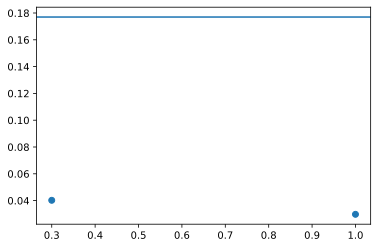

In [90]:
plt.scatter(omega_m, log_l)
plt.axhline(y=0.177)
# plt.xscale('log')

## Check if angular diameter distance are caluclated correctly

In [67]:
import astropy.cosmology as cosmo
import astropy.units as u
cosm = cosmo.wCDM(H0=69.6*u.km / u.s / u.Mpc, Om0=0.286, Ode0=0.714, w0=0)
cosm.angular_diameter_distance(3)

<Quantity 1076.84072557 Mpc>

In [69]:
d_A(z=3, omega_m=0.286, omega_X=0.714, omega_K=0.0, h=0.696, w_X=0.)

1076.8407255747127

## Figures

In [ ]:
# Fig. 2(a)
plt.figure()
plt.scatter(data['z'], data['f_gas_SCDM'], c='black')
plt.errorbar(data['z'], data['f_gas_SCDM'],yerr=data['sigma_SCDM'], linestyle="None", c='black')
plt.xlim([0, 1])
plt.ylim([0.05, 0.23])